In [2]:


import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
data = pd.read_csv(r"C:\Users\23adsb58\Documents\bank\bank.csv")
print(data.columns)



Index(['age;"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"'], dtype='object')


Columns: Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

Training Batch GD...
Epoch 1: train_loss=0.7011, val_loss=0.6929, val_acc=0.5177
Epoch 2: train_loss=0.6975, val_loss=0.6896, val_acc=0.5664
Epoch 3: train_loss=0.6927, val_loss=0.6863, val_acc=0.6298
Epoch 4: train_loss=0.6904, val_loss=0.6831, val_acc=0.6844
Epoch 5: train_loss=0.6873, val_loss=0.6799, val_acc=0.7080
Epoch 6: train_loss=0.6839, val_loss=0.6767, val_acc=0.7301
Epoch 7: train_loss=0.6798, val_loss=0.6736, val_acc=0.7640
Epoch 8: train_loss=0.6768, val_loss=0.6706, val_acc=0.7994
Epoch 9: train_loss=0.6746, val_loss=0.6675, val_acc=0.8230
Epoch 10: train_loss=0.6699, val_loss=0.6645, val_acc=0.8363
Epoch 11: train_loss=0.6683, val_loss=0.6615, val_acc=0.8510
Epoch 12: train_loss=0.6646, val_loss=0.6586, val_acc=0.8599
Epoch 13: train_loss=0.6605, val_l

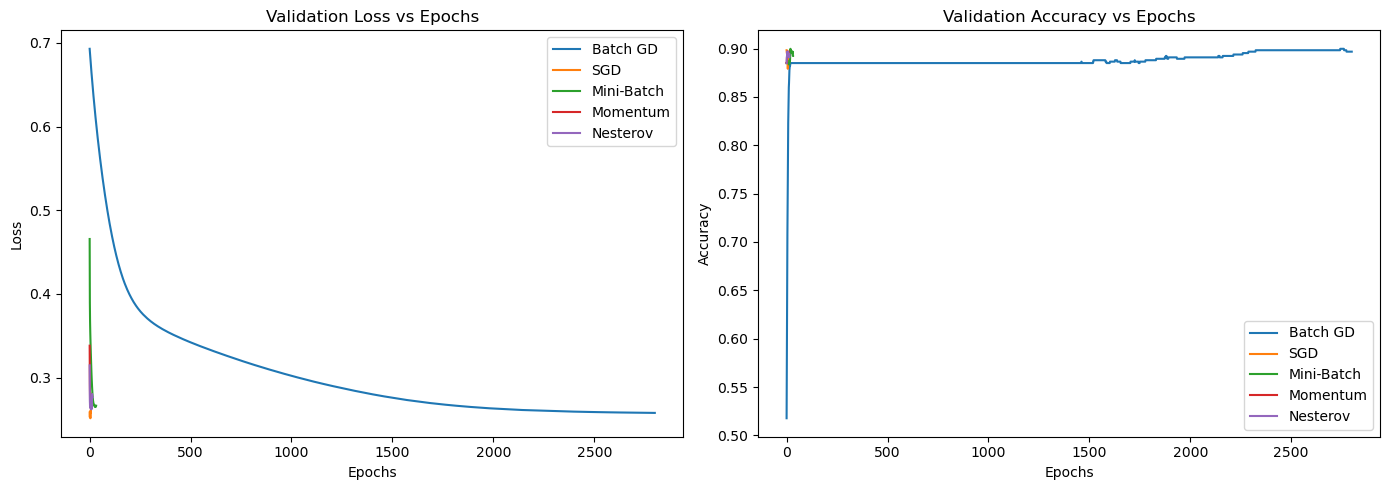


Best Optimizer: Batch GD
Accuracy : 0.8939617083946981
Precision: 0.5576923076923077
Recall   : 0.3717948717948718
F1-score : 0.4461538461538462


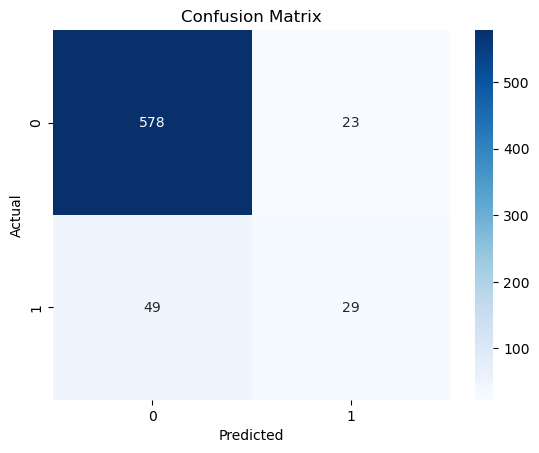

In [6]:
# ============================================================
# Experiment: Evaluation of Optimization Techniques
# Dataset: UCI Bank Marketing - bank.csv
# Delimiter: ;
# Target variable: y
# ============================================================

import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 1. Reproducibility
# ------------------------------------------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# ------------------------------------------------------------
# 2. Load dataset (with correct delimiter)
# ------------------------------------------------------------
CSV_PATH = r"C:\Users\23adsb58\Documents\bank\bank.csv"  # <-- your CSV path

# Correctly read semicolon-separated CSV
data = pd.read_csv(CSV_PATH, sep=';', engine='python')

# Verify columns
print("Columns:", data.columns)

# ------------------------------------------------------------
# 3. Preprocessing
# ------------------------------------------------------------
# Encode target column
data['y'] = data['y'].map({'yes': 1, 'no': 0})

# One-hot encode categorical features
data = pd.get_dummies(data, drop_first=True)

# Split features and labels
X = data.drop('y', axis=1)
y = data['y']

# Standardize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train / Validation / Test split (70 / 15 / 15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

# ------------------------------------------------------------
# 4. Convert to PyTorch datasets
# ------------------------------------------------------------
def make_dataset(X, y):
    return TensorDataset(
        torch.tensor(X, dtype=torch.float32),
        torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
    )

train_ds = make_dataset(X_train, y_train)
val_ds   = make_dataset(X_val, y_val)
test_ds  = make_dataset(X_test, y_test)

# ------------------------------------------------------------
# 5. Neural network architecture
# ------------------------------------------------------------
class BankNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# ------------------------------------------------------------
# 6. Training function with early stopping
# ------------------------------------------------------------
def train_model(optimizer_fn, batch_size):
    model = BankNet(X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optimizer_fn(model)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_val_loss = float("inf")
    best_state = None
    patience = 5
    counter = 0

    epoch = 0
    start_time = time.time()

    while True:
        epoch += 1
        # -------- Training --------
        model.train()
        train_losses, y_true, y_pred = [], [], []

        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            y_true.extend(yb.numpy())
            y_pred.extend((preds > 0.5).float().numpy())

        train_acc = accuracy_score(y_true, y_pred)

        # -------- Validation --------
        model.eval()
        val_losses, y_true, y_pred = [], [], []

        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())
                y_true.extend(yb.numpy())
                y_pred.extend((preds > 0.5).float().numpy())

        val_loss = np.mean(val_losses)
        val_acc = accuracy_score(y_true, y_pred)

        history["train_loss"].append(np.mean(train_losses))
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # Print progress
        print(f"Epoch {epoch}: train_loss={np.mean(train_losses):.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

        # -------- Early stopping --------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            break

    training_time = time.time() - start_time
    model.load_state_dict(best_state)

    return model, history, training_time

# ------------------------------------------------------------
# 7. Optimizers
# ------------------------------------------------------------
lr = 0.01

optimizers = {
    "Batch GD": lambda m: torch.optim.SGD(m.parameters(), lr=lr),
    "SGD": lambda m: torch.optim.SGD(m.parameters(), lr=lr),
    "Mini-Batch": lambda m: torch.optim.SGD(m.parameters(), lr=lr),
    "Momentum": lambda m: torch.optim.SGD(m.parameters(), lr=lr, momentum=0.9),
    "Nesterov": lambda m: torch.optim.SGD(m.parameters(), lr=lr, momentum=0.9, nesterov=True)
}

batch_sizes = {
    "Batch GD": len(train_ds),
    "SGD": 1,
    "Mini-Batch": 32,
    "Momentum": 32,
    "Nesterov": 32
}

# ------------------------------------------------------------
# 8. Train all optimizers
# ------------------------------------------------------------
results = {}

for name in optimizers:
    print(f"\nTraining {name}...")
    model, history, t = train_model(
        optimizers[name],
        batch_sizes[name]
    )
    results[name] = {
        "model": model,
        "history": history,
        "time": t
    }

# ------------------------------------------------------------
# 9. Comparative plots
# ------------------------------------------------------------
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for name in results:
    plt.plot(results[name]["history"]["val_loss"], label=name)
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
for name in results:
    plt.plot(results[name]["history"]["val_acc"], label=name)
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 10. Test set evaluation
# ------------------------------------------------------------
best_optimizer = max(results, key=lambda k: max(results[k]["history"]["val_acc"]))
best_model = results[best_optimizer]["model"]

best_model.eval()
with torch.no_grad():
    test_preds = best_model(torch.tensor(X_test, dtype=torch.float32))
    test_preds = (test_preds > 0.5).float().numpy()

print("\nBest Optimizer:", best_optimizer)
print("Accuracy :", accuracy_score(y_test, test_preds))
print("Precision:", precision_score(y_test, test_preds))
print("Recall   :", recall_score(y_test, test_preds))
print("F1-score :", f1_score(y_test, test_preds))

cm = confusion_matrix(y_test, test_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
